# 子结构操作
RDKit包含了一些修改分子的函数，这些函数可以方便地对分子进行子结构删除/替换等操作。更复杂的操作可以看Chemical Reactions中相关的功能。

## 1.删除子结构
* 先初始化一下<br />
定义一个苯丙氨酸分子，要把苯甲基删掉，变成甘氨酸

In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
m = Chem.MolFromSmiles('OC(=O)C(N)Cc1ccccc1')
m = Chem.MolFromSmiles('c1ccccc1CC(N)C(=O)O')
patt = Chem.MolFromSmarts('Cc1ccccc1')

* 查看patt是否在m中：GetSubstructMatches()<br />
返回值是原分子中与子结构匹配的原子索引

In [2]:
matches = m.GetSubstructMatches(patt)
matches

((6, 5, 4, 3, 2, 1, 0),)

* 查看分子及高亮显示子结构

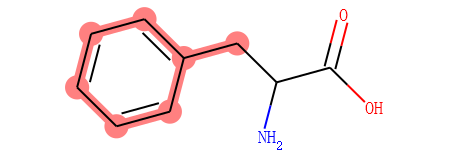

In [3]:
m

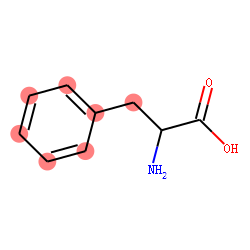

In [4]:
Draw.MolToImage(m, (250,250), highlightAtoms=matches[0])

* **删除子结构：DeleteSubstructs(mol, query, onlyFrags, useChirality)**<br />
mol: 要操作的mol对象<br />
query: 要操作的子结构<br />
onlyFrags: 默认False，即只要匹配一致就删除。为True时，只有当匹配且为一个单独的片段才删除<br />
useChirality: 匹配手性，默认False<br />
原始的分子不会被改变，新的分子将作为返回值返回

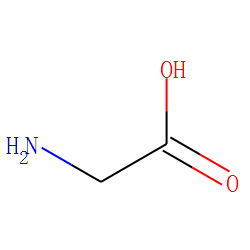

In [5]:
rm = Chem.DeleteSubstructs(m, patt)
Draw.MolToImage(rm, (250,250))

## 2.替换子结构
现在把苯甲基变成羟甲基，也就是丝氨酸
* 设置要替换的结构

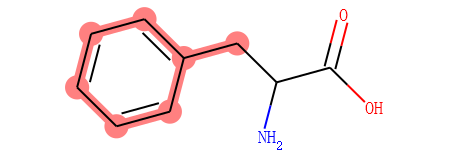

In [6]:
repl = Chem.MolFromSmiles('CO')
m.GetSubstructMatch(patt)
m

* **替换子结构：ReplaceSubstructs(mol, query, replacement, replaceAll, replacementConnectionPoint, useChirality)**<br />
mol: 要操作的mol对象<br />
query: 要操作的子结构<br />
replacement：要替换上去的结构<br />
replaceAll: 默认False，即如果出现多个匹配的子结构，那就进行多次替换并产生不同的新分子。为True时，对所有匹配结构进行替换并产生一个分子<br />
replacementConnectionPoint：默认0，从哪里成键<br />
useChirality: 匹配手性，默认False

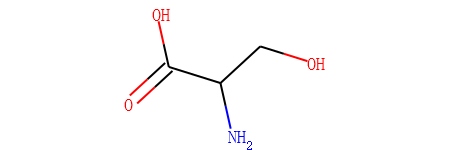

In [7]:
rms = AllChem.ReplaceSubstructs(m, patt, repl)
rms[0]

* 苯丙氨酸变成异亮氨酸<br />
replacementConnectionPoint：默认0，要从哪个原子处成键，这里选择1或2

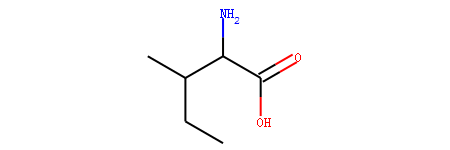

In [8]:
repl = Chem.MolFromSmiles('CCCC')
rms = AllChem.ReplaceSubstructs(m, patt, repl, replacementConnectionPoint=1)
rms[0]

* 有时也会产生一些奇奇怪怪的结构，比如生成个乙酸乙酯<br />
patt中的"[$(OC=O)]"表示寻找羟基氧，而非羰基氧。对SMARTS不明白的可以看看另一篇文章：SMARTS规则速查表。

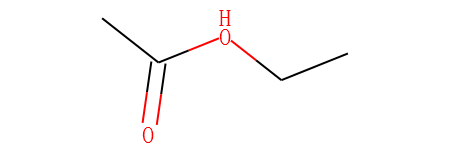

In [9]:
m = Chem.MolFromSmiles('CC(=O)O')
patt = Chem.MolFromSmarts('[$(OC=O)]')
repl = Chem.MolFromSmiles('OCC')
rms = Chem.ReplaceSubstructs(m, patt, repl)
rms[0]

* 检查分子：Chem.SanitizeMol(rms[0])<br />
计算凯库勒式、检查化合价、芳香性、共轭及杂化

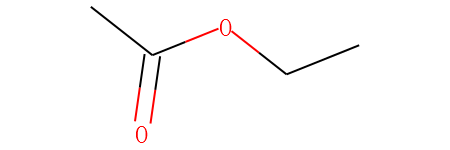

In [10]:
Chem.SanitizeMol(rms[0])
rms[0]

## 3.切掉侧链
保留氨基酸的母核：NH2-C-COOH
* **切掉侧链，保留母核：ReplaceSidechains(mol, coreQuery , useChirality)**<br />
mol: mol对象<br />
coreQuery: 母核结构<br />
useChirality: 匹配手性，默认False

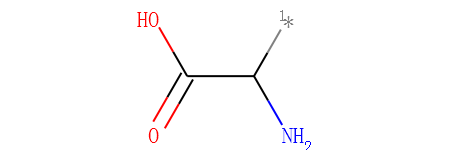

In [11]:
m = Chem.MolFromSmiles('c1ccccc1CC(N)C(=O)O')
core = Chem.MolFromSmiles('NCC(=O)O')
m1 = Chem.ReplaceSidechains(m, core)
m1

## 4.切掉母核
保留R基，去除母核
* **切掉母核：ReplaceCore(mol, core , ...)**<br />
mol: mol对象<br />
coreQuery: 母核结构<br />
保留侧链，去掉母核

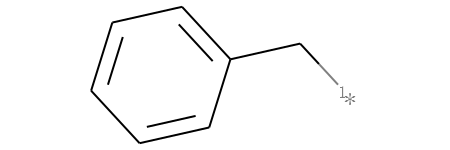

In [12]:
r = AllChem.ReplaceCore(m, core)
r

* **获取侧链片段：GetMolFrags(mol, asMols, sanitizeFrags, ...)**<br />
asMols：默认False，即返回原子索引。True时，将片段转成mol对象<br />
sanitizeFrags：默认True，即返回时会进行检查。

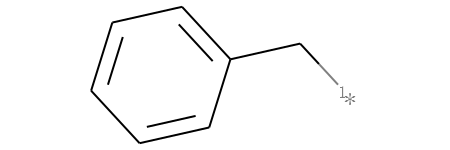

In [13]:
side_mols = Chem.GetMolFrags(r, asMols=True)
side_mols[0]

* **获取多个侧链片段**

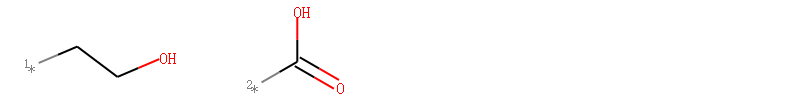

In [14]:
m1 = Chem.MolFromSmiles('c1c(CCO)ncnc1C(=O)O')
core = Chem.MolFromSmiles('c1cncnc1')
tmp = AllChem.ReplaceCore(m1, core)
side_mols = Chem.GetMolFrags(tmp, asMols=True)
Draw.MolsToGridImage([x for x in side_mols], molsPerRow=4, subImgSize=(200,100))

## 5.其他分子切分方法
- BRICS算法，基于可合成的键进行拆分分子
- Recap算法，模仿实验中的正向合成来做逆向拆分

此外，rdkit中还提供了非常灵活的函数，用来对指定的键进行拆解来获得分子片段，下面以断裂掉所有环中原子和环外原子间的键为例，来做一个简要的介绍。
- 先定义一个包含环状结构的分子
- 通过SMARTS定义要断裂键所涉及的原子
- 查找匹配所有符合SMARTS的子结构

((0, 1), (4, 3), (6, 5), (7, 8))


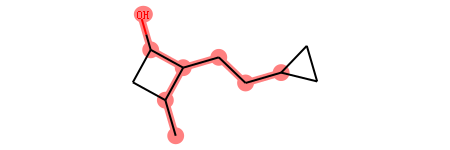

In [15]:
m = Chem.MolFromSmiles('CC1CC(O)C1CCC1CC1')
patt = Chem.MolFromSmarts('[!R][R]')
bis = m.GetSubstructMatches(patt)
print(bis)
m

In [16]:
Draw.MolToFile(m, 'data/substructure_delete_replace_split_6.png', size=(150, 150))

- 遍历匹配上的原子对
- 通过匹配得到的原子索引，获取相应的键：GetBondBetweenAtoms()
- 获得键的索引：GetIdx()

In [17]:
bs = [m.GetBondBetweenAtoms(x, y).GetIdx() for x, y in bis]
bs

[0, 3, 5, 7]

- 通过断裂键来获取片段：FragmentOnBonds(mol, bondIndices, addDummies, bondTypes , ...)<br />
mol：要拆解的分子<br />
bondIndices：键的索引<br />
addDummies：默认True，即添加一个虚原子来标明断裂的位置<br />
bondTypes：片段和虚原子之间用什么键连接，默认是单键

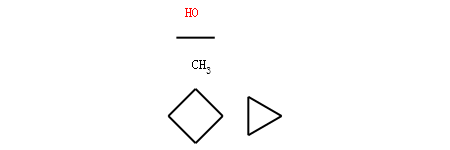

In [18]:
nm = Chem.FragmentOnBonds(m, bs, addDummies=False)
nm

In [19]:
Draw.MolToFile(nm, 'data/substructure_delete_replace_split_7.png', size=(200, 200))

- 从一个混合物中，获取所有片段：Chem.GetMolFrags()

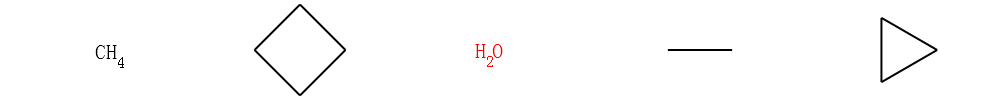

In [20]:
mol_list = Chem.GetMolFrags(nm, asMols=True)
img = Draw.MolsToGridImage(mol_list, molsPerRow=5, subImgSize=(200,100))
img

In [21]:
img.save('data/substructure_delete_replace_split_8.png')

- 默认情况下，使用FragmentOnBonds()时，断开的位置会用被移开的原子序号进行标记，我们也可以通过设置dummyLabels参数来自定义序号。该参数中每个元素的第一个数字表示键连接的第一个原子（键的起始原子），第二个数字表示键连接的第二个原子（键的结尾原子）。接着使用上面的例子说明一下，将环上的原子标记为1，将非环上的原子标记为10。

In [22]:
m = Chem.MolFromSmiles('CC1CC(O)C1CCC1CC1')
patt = Chem.MolFromSmarts('[!R][R]')
bis = m.GetSubstructMatches(patt)
bs = []
labels = []
for bi in bis:
    b = m.GetBondBetweenAtoms(bi[0], bi[1])
    if b.GetBeginAtomIdx() == bi[0]:
        labels.append((10, 1))
    else:
        labels.append((1, 10))
    bs.append(b.GetIdx())
nm = Chem.FragmentOnBonds(m, bs, dummyLabels=labels)
Chem.MolToSmiles(nm, True)

'[1*]C.[1*]CC[1*].[1*]O.[10*]C1CC([10*])C1[10*].[10*]C1CC1'